# Altitude Rockets Designs

This notbook provides descriptions, equations and renderings of several nose cone shapes commonly used in hobbly rocketry. The notebook leverages serveral common packages such as matplotlib, numpy for data handling and 2D graphing and some less-common packages viewscad, solidpython and OpenSCAD for 3D rendering.

Our first step is to import these packages.

In [354]:
from os.path import expanduser
import matplotlib.pyplot as plt
import numpy as np
import viewscad
from solid import *

The parameters for the fins define the shape of the symetric airfoil as well as the minimum printible thickness. Since the model is printed using spiral mode, we *must* allow for two paths along the fin leading and trailing edges.

In [355]:
body_length = 110
body_diameter = 14.1
body_radius = body_diameter/2

motor_diameter = 13
motor_radius = motor_diameter/2

nose_length = 21.7
nose_radius = body_radius

bay_diameter = 13.15
bay_radius = bay_diameter/2
bay_body = 20
bay_nose = 5

fin_chord = 20
fin_span = 18.8
fin_max = 2
fin_min = 0.25

lug_height = 5
lug_thick = 2
lug_od = 4.4
lug_or = lug_od/2

cp_from_base = 31.6

The smoothing factor defines the number of segments used to render objects and the number of points for defining curves. We also create an array of zero for convienence.

In [356]:
SMOOTH=500
zero = np.array([0])
r = viewscad.Renderer()


## Nose Cone

The elliptical nose cone shape is one-half of an ellipse, with the major axis being the centerline and the minor axis being the base of the nose cone. A rotation of a full ellipse about its major axis is called a prolate spheroid, so an elliptical nose shape would properly be known as a prolate hemispheroid. This has been chosen  due to the blunt nose and tangent base, which is generally considered superior for model rocketry altitude optimisation use.

The profile is defined as $y=R{\sqrt  {1-{x^{2} \over L^{2}}}}$

Calculate the nose cone profile

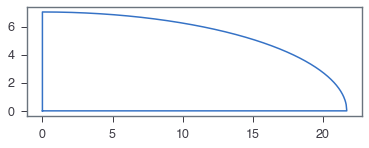

In [357]:
x = np.linspace(0, nose_length, int(SMOOTH))
f = lambda x: nose_radius * np.sqrt(1-(x**2/nose_length**2))
y = f(x)

xplt = np.concatenate((zero, x, zero))
yplt = np.concatenate((zero, y, zero))

plt.axes().set_aspect("equal")    
plt.plot(xplt, yplt)
    
points = np.vstack((yplt, xplt)).T

rotate the profile around the z-axis to create a solid object and output an .stl for subsequent use.

In [358]:
p = rotate_extrude(360, segments=SMOOTH)(polygon(points))

r.render(p, outfile=expanduser("~") + '/GGA_nose.stl')

## Altimeter Bay
This need to be printed with seveal bottom layers to provide protection for the altimiter, which is housed mostly in the nose cone.

In [359]:
p = cylinder(r=motor_radius, h=bay_body, segments=SMOOTH)
p += translate([0, 0, bay_body])(cylinder(r=bay_radius, h=bay_nose, segments=SMOOTH))
                                         
r.render(p, outfile=expanduser("~") + '/GGA_altbay.stl')

## The Fins
The fins are square, which provides an optimal balance between stability and drag. The airfoil applied to the fins is paticularly important as these shows significant improvement in effieiency.

A symmetric NACA Four-Digit Series airfoil has been chosen, which is most approriate for this use and significantly easier to calculate. The formula for the shape of a NACA 00xx foil, with "x" being replaced by the percentage of thickness to chord, is

$y_t=5t\ [0.2969\sqrt{x}-0.1260x-0.3516x^2+0.2843x^3-0.1015x^4]$

where:

* $x$ is the position along the chord from $0$ to $1.00$, $(0$ to $100\%)$

* $y_t$ is the half thickness at a given value of $x$ (centerline to surface), and

* $t$ is the maximum thickness as a fraction of the chord (so $t$ gives the last two digits in the NACA 4-digit denomination divided by 100).

Allocate an array to represent $x$ and apply the function.

In [360]:
x = np.linspace(0, 1, fin_chord*100)
f = lambda x: (5*fin_max)*(0.2969*np.sqrt(x)-0.1260*x-0.3516*x**2+0.2843*x**3-0.1015*x**4)

y=f(x)

Create a array to scale $x$ to $c$ and ensure that $y$ $\ge$ min thickness . Then add a $(c,\ 0)$ and $(0, 0)$ coordnate to the x and y arrays to ensure a closed polygon.

In [361]:
x_scale = np.linspace(0, fin_chord, int(fin_chord*100))
y[y < fin_min] = fin_min

x_u = np.concatenate((zero, x_scale, np.array([fin_chord])))
x_l = x_u

y_u = np.concatenate((zero, y, zero))
y_l = np.negative(y_u)

The coordinates $(x_U,y_U)$ of the upper airfoil surface, and $(x_L,y_L)$ of the lower airfoil surface are:

$x_U=x_L=x,\qquad y_U=+y_t,\qquad \text{and}\qquad y_L=-y_t.$


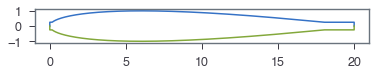

In [362]:
plt.axes().set_aspect("equal")
plt.plot(x_u, y_u)
plt.plot(x_l, y_l)

Build a set of points describing the airfoil

In [363]:
fin_points = np.vstack((np.concatenate((y_u, y_l)), np.concatenate((x_u, x_l)))).T

## Body
The body is simply a minimum diameter tube with the fins attached at $120^\circ$ angles.

In [364]:
fin = translate([0, body_radius, fin_chord])(
      (rotate([270, 0, 0]))
      (linear_extrude(height=fin_span)
      (polygon(fin_points))))

p = cylinder(d=body_diameter, h=body_length, segments=SMOOTH)

r.render(p, outfile=expanduser("~") + '/GGA_body.stl')

p += (fin) 
p += rotate([0,0,120])(fin)
p += rotate([0,0,240])(fin)


r.render(p, outfile=expanduser("~") + '/GGA_airframe.stl')

## Launch Lug

Optimum altitude will be reached using a launch tower or piston. A laung lug may also be used wher this apperatus is not available. In this case, the lub becomes an integral part of the airframe.

In [365]:
points = np.array([[lug_od,lug_thick],
                   [0,lug_height],
                   [0,cp_from_base-lug_height],
                   [lug_od,cp_from_base-lug_thick],
                   [lug_od,lug_thick]])

lug = translate([0,lug_or,0])(cylinder(d=lug_od, h=cp_from_base))
lug -= translate([-lug_or,0,0])(
         (rotate([90,0,90]))
         (linear_extrude(height=lug_od)
         (polygon(points=points))))

p += rotate([0,0,60])(translate([0,body_radius,0])(lug))

r.render(p, outfile=expanduser("~") + '/GGA_airframe_l.stl')

## References
[1]